---
layout: page
title: Regressão Linear
nav_order: 12
---

[<img src="https://github.com/icd-ufmg/icd-ufmg.github.io/blob/master/_lessons/colab_favicon_small.png?raw=1" style="float: right;">](https://colab.research.google.com/github/flaviovdf/icd-bradesco/blob/master/_lessons/12-Linear.ipynb)


# Tópico 12 - Regressão Linear Simples

{: .no_toc .mb-2 }

Entendimento de relação entre dados.
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados

1. Entemder os mínimos quadrados
1. Entender o coeficiente de pearson e o R2.
1. Executar regressões em python

In [1]:
# -*- coding: utf8

from scipy import stats as ss

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('ggplot')

## Introdução

Antes de iniciar o nosso estudo da regressão, vamos pensar em um modelo que tenta capturar o valor médio no eixo y. Para uma base de dados unidimensional (apenas Y), a média ($\bar{y}$) é um bom estimador. Isto é, imagine que você está em uma sala de aula e entra um novo aluno na sala. Posso prever alguma característica deste aluno (por exemplo, o seu rendimento escolar) usando a média dos outros alunos em sala de aula.

Agora, como podemos proceder quando temos duas variáveis X e Y? Em uma aula anterior, usamos a função de correlação para medir a força da relação linear entre duas variáveis. Para a maioria das aplicações, saber que esse relacionamento linear existe não é suficiente. Queremos ser capazes de entender a natureza do relacionamento. É aqui que vamos usar a regressão linear simples.

Vamos olhar para uma bas bases dados que ajudaram a criar a regressão linear.

## Poor Person's KNN  (Vizinhos Próximos Implementado de Forma Simples)

Vamos iniciar com a base de dados original analisada por [Galton](https://en.wikipedia.org/wiki/Francis_Galton). Tal base captura altura de um filho, após alguns anos, com base na altura média dos pais. O problema sendo estudado era prever qual vai ser a altura futura de uma criança usando apenas a idade dos pais como entrada. Como temos um pai e uma mãe, usamos a média das alturas entre os dois. Então temos que:

1. X é a altura média dos pais
1. Y é a altura da criança após alguns anos (o mesmo número de anos para toda criança)

In [2]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/16-RegressaoLinear/galton.csv')
df.head()

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,78.5,67.0,75.43,4,1,male,73.2
1,1,78.5,67.0,75.43,4,2,female,69.2
2,1,78.5,67.0,75.43,4,3,female,69.0
3,1,78.5,67.0,75.43,4,4,female,69.0
4,2,75.5,66.5,73.66,4,1,male,73.5


Abaixo temos a dispersão dos dados

Text(0.5, 1.0, 'Regressão linear simples')

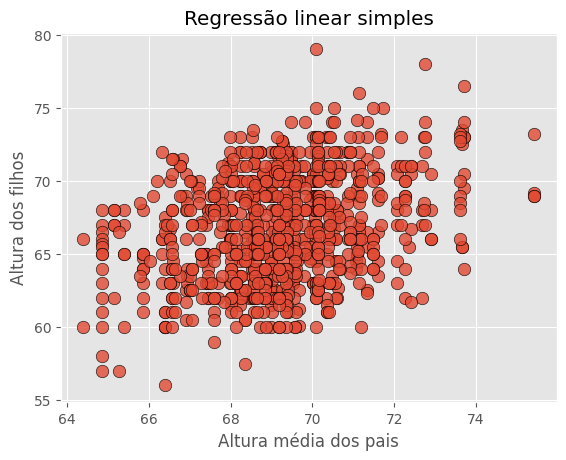

In [3]:
x = df['midparentHeight'].values
y = df['childHeight'].values

plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.xlabel('Altura média dos pais')
plt.ylabel('Altura dos filhos')
plt.title('Regressão linear simples')

Uma forma de capturar a correlação é fazer uma regressão de vizinhos próximos (nearest neighbors). Para tal, precisamos agrupar, no eixo-x, pontos próximos um dos outros. É possível fazer o mesmo nos eixos x e y usando uma distância euclideana. Por simplicidade vamos agrupar apenas em x. No caso particular destes dados onde os valores são bem espalhados no eixo x, podemos simplesmente arredondar os números

In [4]:
copy = df[['midparentHeight', 'childHeight']].copy()
copy['midparentHeight'] = copy['midparentHeight'].round()

Agrupar por x e tirar a média de y.

In [5]:
model = copy.groupby('midparentHeight').mean()
model.head()

,childHeight
midparentHeight,
64.0,63.000000
65.0,64.229630
66.0,64.350000
67.0,65.535632
68.0,66.240458


Observando o modelo.

Text(0.5, 1.0, 'Regressão linear simples')

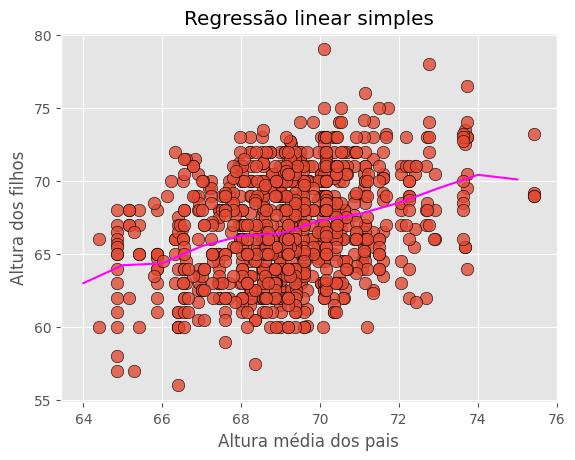

In [6]:
x_nn = model.index
y_nn = model.values
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x_nn, y_nn, color='magenta')
plt.xlabel('Altura média dos pais')
plt.ylabel('Altura dos filhos')
plt.title('Regressão linear simples')

Previsão: Para um novo ponto, arredondar seu peso. Ver valor de y_nn

In [7]:
idade_media_pais = 71
model.loc[71.0]

childHeight    67.740594
Name: 71.0, dtype: float64

Observe que o modelo acima é muito perto de uma reta. Este é um dos pontos e partidas para entender a correlação linear. Precisamos de alguma forma:

1. Capturar a média de valores próximos um dos outros em x
1. Capturar a média de valores próximos um dos outros em y

Resolvemos o (1) problema nos dados acima com um round. No caso (2) com um group-by e mean. Observe como o modelo é quase o mesmo quando z-normalizamos os dados.

In [8]:
znormed = df[['midparentHeight', 'childHeight']].copy()
znormed = (znormed - znormed.mean()) / znormed.std(ddof=1)
znormed.head()

,midparentHeight,childHeight
0,3.452802,1.803190
1,3.452802,0.685637
2,3.452802,0.629760
3,3.452802,0.629760
4,2.470762,1.887006


In [9]:
x = znormed['midparentHeight'].copy()
y = znormed['childHeight'].copy()

In [10]:
znormed['midparentHeight'] = znormed['midparentHeight'].round()
model = znormed.groupby('midparentHeight').mean()

Text(0.5, 1.0, 'Regressão linear simples')

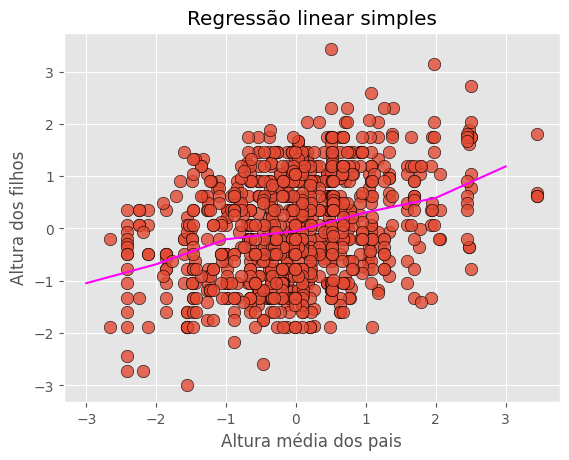

In [11]:
x_nn = model.index
y_nn = model.values
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x_nn, y_nn, color='magenta')
plt.xlabel('Altura média dos pais')
plt.ylabel('Altura dos filhos')
plt.title('Regressão linear simples')

# Regressão Linear Simples

A ideia da regressão linear é similar ao exemplo acima. De forma simples, queremos uma reta possível de explicar tando a dispersão em x quanto em y, `na média`. Tal reta deve se aproximar da média dos dois valores quando vistos em janelas (estilo o NN acima). Em particular, você supõe que existem constantes $\alpha$ (alfa) e $\beta$ (beta) tais que:

$$\hat{y}_i = \beta x_i + \alpha + \epsilon_i$$

Idealmente, vamos conseguir capturar o valor médio de $y_i$ para grupos de valores próximos em $x_i$. $\epsilon_i$ é um termo de erro (esperançosamente pequeno) que representa o fato de que existem outros fatores não explicados por este modelo simples.

Como escolhemos alfa e beta? Bem, qualquer escolha de alfa e beta nos dá uma saída prevista para cada entrada $x_i$. Como sabemos a saída real $y_i$, podemos calcular o erro de cada par. Computa o valor $\epsilon_i$.

In [12]:
def error(alpha, beta, x, y):
    model = beta * x + alpha
    return y - model

Observe o erro médio para um primeiro modelo

In [13]:
x = df['midparentHeight'].values
y = df['childHeight'].values

alpha = 1
beta = 0.5
e = error(alpha, beta, x, y)
e.mean()

31.142544967880085

Text(0.5, 1.0, 'Regressão linear simples')

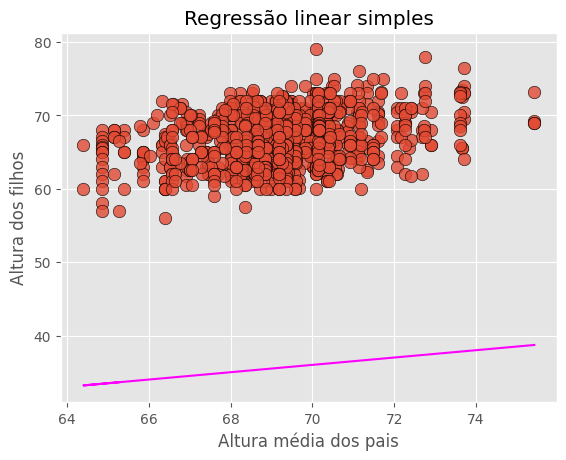

In [14]:
x = df['midparentHeight'].values
y = df['childHeight'].values

y_model = beta * x + alpha

plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y_model, color='magenta')
plt.xlabel('Altura média dos pais')
plt.ylabel('Altura dos filhos')
plt.title('Regressão linear simples')

Agora para um segundo.

In [15]:
alpha = 22
beta = 0.5
e = error(alpha, beta, x, y)
e.mean()

10.142544967880088

Text(0.5, 1.0, 'Regressão linear simples')

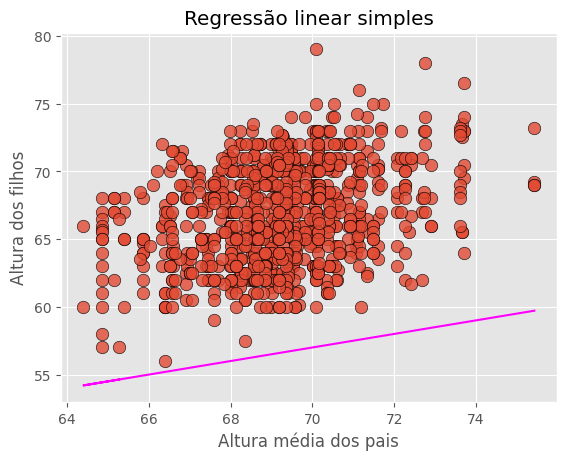

In [16]:
x = df['midparentHeight'].values
y = df['childHeight'].values

y_model = beta * x + alpha
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y_model, color='magenta')
plt.xlabel('Altura média dos pais')
plt.ylabel('Altura dos filhos')
plt.title('Regressão linear simples')

O segundo modelo é bem melhor. Porém os dois são péssimos. Para facilitar a nossa vida, vamos fazer uso da soma dos erros ao quadrado. Isto vai nos ajudar nas derivadas.

Somamos os erros quadrados:

In [17]:
def sum_of_squared_errors(alpha, beta, x, y):
    return (error(alpha, beta, x, y) ** 2).sum()

A *solução de mínimos quadrados (least squares solution)*  é escolher o alfa e o beta que tornam o `sum_of_squared_errors` o menor possível. Para chegar em tais valores, podemos ver o erro como uma função de $\alpha$, $\beta$. Vamos iniciar com o caso normalizado. Aqui $\alpha=0$.

### Dados Normalizados

Lembre-se que na z-normalização, os dados de X e Y ficam com média 0 e desvio 1. Em particular: $x'_i = \frac{x_i - \bar{x}}{s_x}$ e $y'_i = \frac{y_i - \bar{y}}{s_y}$. Note como a média dos dados tanto em X quanto em Y é zero:

$$\bar{x'} = n^{-1} \sum_i \frac{x_i - \bar{x}}{s_x}$$

$$\bar{x'} = n^{-1} s^{-1}_x (\sum_i x_i - \bar{x} \sum_i 1)$$

$$\bar{x'} = n^{-1} s^{-1}_x (\sum_i x_i - \bar{x} n)$$

$$\bar{x'} = n^{-1} s^{-1}_x (\sum_i x_i - x_i)$$

$$\bar{x'} = n^{-1} s^{-1}_x (0) = 0$$

Além do mais, o desvio padrão é 1. Provando:

$$s_{x'} = n^{-1} \sum_i (\frac{x_i - \bar{x}}{s_x} - 0)^2$$
$$s_{x'} = s^{-1}_x n^{-1} \sum_i (x_i - \bar{x})^2$$
$$s_{x'} = s^{-1}_x s_x = 1$$

Como a média dos pontos é (0, 0), a nossa melhor reta vai passar pela origem. Ou seja, $\alpha=0$. Além do mais,  cada ponto dos seus dados é uma reta entre (0, 0) e o ponto $(x'_i, y'_i)$. Neste caso, resolver o problema abaixo para chegar na equação da reta:

$$L(\beta) = \sum_i (y'_i - \hat{y}'_i)^2$$

$$L(\beta) = \sum_i (y'_i - \beta x'_i)^2$$

$$L(\beta) = \sum_i y'^2_i - 2 \beta x'_i y'_i + \beta^2 x'^2_i$$

Derivando a função em $\beta$:

$$\frac{d}{d\beta} L(\Theta) = -\sum_i 2 x'_i y'_i + 2 \beta x'^2_i$$

Fazendo $\frac{d}{d\beta}=0$:

$$\beta = \frac{\sum_i x'_i y'_i}{x'^2_i}$$

Nos slides discutimos como tal solução captura é uma função da covariância dos dados.

### Dados Originais

Agora vamos resolver sem normalizar os dados. Vamos definir $\Theta = [\alpha, \beta]$, isto é, um vetor com alfa e beta.

$$L(\Theta) = \sum_i (y_i - \hat{y}_i)^2$$

$$L(\Theta) = \sum_i (y_i - \beta x_i + \alpha)^2$$

Resolvendo o quadrado dentro do somatório temos:

$$L(\Theta) = \sum_i (y_i^2 + \alpha^2 + x_i^2\beta^2 - 2 \beta \alpha x_i - 2 \beta x_i y_i + 2\alpha y_i)$$

Derivando em relação a $\alpha$:

$$\frac{d}{d\alpha} L(\Theta)= \sum_i (2\alpha - 2 \beta x_i + 2\beta y_i)$$

Derivando em relação a $\beta$:

$$\frac{d}{d\beta} L(\Theta) = \sum_i (2x_i^2\beta - 2 \alpha x_i + 2 x_i y_i)$$

Para resolver otimizar esta função precisamos setar as duas derivadas para zero.

$$\frac{d}{d\alpha} L(\Theta) = 0$$

$$\frac{d}{d\beta} L(\Theta) = 0$$

Após isto, podemos resolver os valores ótimos de $\alpha$ e $\beta$. Note que esta é uma otimização um pouco chata de resolve.

\begin{align}
 \alpha & = \bar{y} - \beta\,\bar{x}, \\[5pt]
  \beta &= \frac{ \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) }{ \sum_{i=1}^n (x_i - \bar{x})^2 } \\[6pt]
            &= \frac{ \operatorname{Cov}(x, y) }{ \operatorname{Var}(x) } \\[5pt]
            &= r_{xy} \frac{s_y}{s_x}. \\[6pt]
\end{align}

In [18]:
def least_squares_fit(x, y):
    correlationxy = ss.pearsonr(x, y)[0]
    beta = correlationxy * np.std(y, ddof=1) / np.std(x, ddof=1)
    alpha = np.mean(y) - beta * np.mean(x)
    return alpha, beta

Sem passar pela matemática exata, vamos pensar em por que isso pode ser uma solução razoável. A escolha do alfa simplesmente diz que quando vemos o valor médio da variável independente $x$, predizemos o valor médio da variável dependente $y$.

A escolha de beta significa que quando o valor de entrada aumenta pelo desvio padrão de $x$, a previsão de $y$ aumenta pela correlação entre $x$ e $y$ multiplicada pelo desvio padrão de $y$ (`correlationxy * np.std(y)`). No caso em que $x$ e $y$ estão perfeitamente correlacionados, um aumento de um desvio padrão em $x$ resulta em um aumento de um desvio padrão de $y$ na predição. Quando eles são perfeitamente anti-correlacionados, o aumento em $x$ resulta em uma *diminuição* no valor da previsão. E quando a correlação é *zero*, o beta é *zero*, o que significa que as alterações em $x$ não afetam a previsão.

Para um pouco mais sobre a intuição dessa fórmula, veja este [vídeo](https://www.khanacademy.org/math/ap-statistics/bivariate-data-ap/least-squares-regression/v/calculating-the-equation-of-a-regression-line).

Text(0.5, 1.0, 'Regressão linear simples')

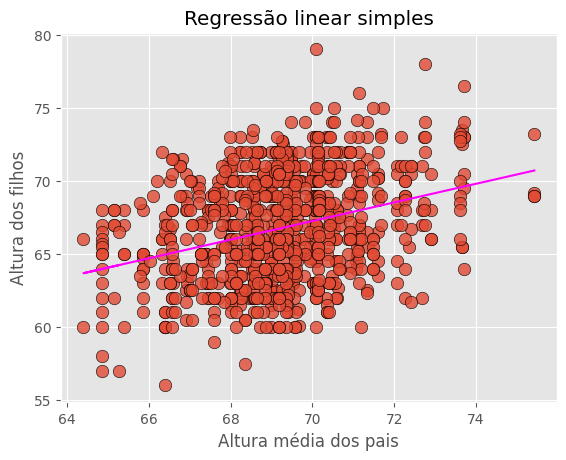

In [19]:
x = df['midparentHeight'].values
y = df['childHeight'].values
alpha, beta = least_squares_fit(x, y)
y_model = beta * x + alpha
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y_model, color='magenta')
plt.xlabel('Altura média dos pais')
plt.ylabel('Altura dos filhos')
plt.title('Regressão linear simples')

In [20]:
alpha, beta

(22.636240549589736, 0.6373608969694791)

Isso fornece valores de alfa = 22,63 e beta = 0,63. Portanto, podemos dizer que crianças vão ser aproximadamente 22 polegadas maiores do que a 63\% da média da altura dos seus pais.

É claro que precisamos de uma maneira melhor de descobrir o quão bem nós ajustamos os dados do que simplesmente encarar o gráfico da regressão. Uma medida comum é o coeficiente de determinação (ou R-quadrado, ou $R^2$, ou R-dois), que mede a fração da variação total na variável dependente (o $y$) que é capturada pelo modelo:

In [21]:
def total_sum_of_squares(y):
    return ((y - y.mean()) ** 2).sum()

def r_squared(alpha, beta, x, y):
    return 1.0 - (sum_of_squared_errors(alpha, beta, x, y) /
                  total_sum_of_squares(y))


In [22]:
r_squared(alpha, beta, x, y)

0.10300883578346631

Agora, escolhemos o alfa e o beta que minimizaram a soma dos quadrados dos erros de previsão. Um modelo linear que poderíamos ter escolhido é "sempre prever a média de $y$" (correspondendo a `alpha = np.mean(y)` e `beta = 0`), cuja soma dos erros quadrados é exatamente igual a sua soma total de quadrados. Isso significa um $R^2$ de zero, que indica um modelo que (obviamente, neste caso) não funciona melhor do que apenas prever a média.

Claramente, o modelo de mínimos quadrados deve ser pelo menos tão bom quanto esse, o que significa que a soma dos erros quadrados é no máximo a soma total de quadrados, o que significa que o $R^2$ deve ser pelo menos zero. E a soma dos erros quadrados deve ser pelo menos $0$, o que significa que o $R^2$ pode ser no máximo $1$.

Quanto maior for o $R^2$, melhor o nosso modelo se ajusta aos dados. Aqui nós calculamos um $R^2$ de $0.10$, o que nos diz que o nosso modelo está fraco ajustar os dados, e que claramente existem outros fatores em jogo.

Observe como o modelo para, visualmente, bem pior ao plotar em outra escala. Existe muita variabilidade no eixo-y para ser capturada.

(55.0, 80.0)

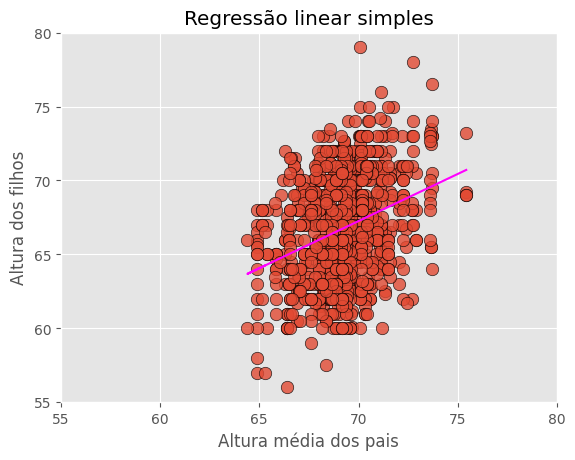

In [23]:
x = df['midparentHeight'].values
y = df['childHeight'].values
alpha, beta = least_squares_fit(x, y)
y_model = beta * x + alpha
plt.scatter(x, y, alpha=0.8, edgecolors='k', s=80)
plt.plot(x, y_model, color='magenta')
plt.xlabel('Altura média dos pais')
plt.ylabel('Altura dos filhos')
plt.title('Regressão linear simples')
plt.xlim((55, 80))
plt.ylim((55, 80))

Por fim, a raiz de $R^2$ é a correlação.

In [24]:
r_squared(alpha, beta, x, y) ** 0.5

0.32094989606395935

In [25]:
ss.pearsonr(x, y)[0]

0.3209498960639593

Formas de interpretar o $R^2$.

1. Quão melhor é o meu modelo de um que retorna apenas a média de y.
1. Quanto da variancia de y é explicada por x. Apenas 10% acima.

Para entender o segundo ponto, o `total_sum_of_squares` é proporcional a variância. Na verdade é $s_y$ * (n-1). Ou seja, sem tirar a média dos desvios quadrados. Sendo $\hat{y}_i$ a nossa previsão.

$$R^2 = \sum_i \frac{(y_i - \bar{y})^2 - (y_i - \hat{y}_i)^2}{(y_i - \bar{y})^2}$$

$(y_i - \bar{y})^2$ define nossa variância. Quanto dela está em $(y_i - \hat{y}_i)^2$. Esta é outra forma de pensar no $R^2$.

## Exemplo prático com Scikit-learn

Abaixo, um exemplo simples mostrando como realizar uma regressão linear utilizando a biblioteca [scikit-learn](https://sklearn.org). Na prática não precisamos fazer tudo do zero como fizemos acima.

In [26]:
stocks = {'Year': [2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016],
          'Month': [12, 11,10,9,8,7,6,5,4,3,2,1,12,11,10,9,8,7,6,5,4,3,2,1],
          'Interest_Rate': [2.75,2.5,2.5,2.5,2.5,2.5,2.5,2.25,2.25,2.25,2,2,2,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75],
          'Unemployment_Rate': [5.3,5.3,5.3,5.3,5.4,5.6,5.5,5.5,5.5,5.6,5.7,5.9,6,5.9,5.8,6.1,6.2,6.1,6.1,6.1,5.9,6.2,6.2,6.1],
          'Stock_Index_Price': [1464,1394,1357,1293,1256,1254,1234,1195,1159,1167,1130,1075,1047,965,943,958,971,949,884,866,876,822,704,719]
         }

df = pd.DataFrame(stocks, columns=['Year','Month', 'Interest_Rate', 'Unemployment_Rate', 'Stock_Index_Price'])

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
X = df[['Interest_Rate']]
y = df['Stock_Index_Price']

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [29]:
predictions = model.predict(X)

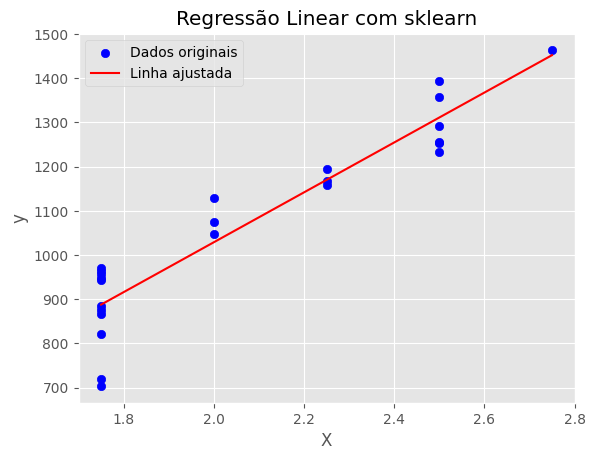

Intercept (alfa): -99.46
Coeficiente (beta): 564.20


In [30]:
plt.scatter(X, y, color='blue', label='Dados originais')
plt.plot(X, predictions, color='red', label='Linha ajustada')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Regressão Linear com sklearn')
plt.legend()
plt.show()

# Exibindo coeficientes
print(f'Intercept (alfa): {model.intercept_:.2f}')
print(f'Coeficiente (beta): {model.coef_[0]:.2f}')

## Exemplo Prático com statsmodels

Caso você tenha um viés mais estatístico, podemos usar o  statsmodels. Aqui teremos descrições de intervalos de confiânça e valores-p.

In [31]:
import statsmodels.api as sm

X = df['Interest_Rate']
y = df['Stock_Index_Price']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:      Stock_Index_Price   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     155.0
Date:                Tue, 15 Apr 2025   Prob (F-statistic):           1.95e-11
Time:                        18:31:11   Log-Likelihood:                -136.94
No. Observations:                  24   AIC:                             277.9
Df Residuals:                      22   BIC:                             280.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -99.4643     95.210     -1.045